In [1]:
# ## install finrl library
# !pip install wrds
# !pip install quantstats
# !pip install torch_geometric
# !pip install swig
# !pip install -q condacolab
# !pip install shimmy
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [5]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (107677, 8)


In [7]:
print(raw_df)

              date        open        high         low       close     volume  \
0       2009-04-01    3.717500    3.892857    3.710357    3.278072  589372000   
1       2009-04-01   48.779999   48.930000   47.099998   34.259613   10850100   
2       2009-04-01   13.340000   14.640000   13.080000   11.493887   27701800   
3       2009-04-01   34.520000   35.599998   34.209999   26.850750    9288800   
4       2009-04-01   27.500000   29.520000   27.440001   19.116177   15308300   
...            ...         ...         ...         ...         ...        ...   
107672  2023-12-29  525.979980  528.239990  523.919983  520.342285    2080100   
107673  2023-12-29  260.570007  261.459991  259.670013  258.866302    4074600   
107674  2023-12-29   37.380001   37.759998   37.320000   35.344772   16205200   
107675  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
107676  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

         tic  day  
0      

In [8]:
# INDICATORS = ['macd',
#             'rsi_30',
#             'cci_30',
#             'dx_30']

In [9]:
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# fe = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list = INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature = False)

# processed = fe.preprocess_data(df)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

# # here you can see the engineered features are added to each stock day
# print(processed)


In [10]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)

In [11]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713
AMGN,3713,3713,3713,3713,3713,3713,3713
AXP,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713
CAT,3713,3713,3713,3713,3713,3713,3713
CRM,3713,3713,3713,3713,3713,3713,3713
CSCO,3713,3713,3713,3713,3713,3713,3713
CVX,3713,3713,3713,3713,3713,3713,3713
DIS,3713,3713,3713,3713,3713,3713,3713


In [12]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 29


In [13]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

df_train.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,2960,2960,2960,2960,2960,2960,2960
AMGN,2960,2960,2960,2960,2960,2960,2960
AXP,2960,2960,2960,2960,2960,2960,2960
BA,2960,2960,2960,2960,2960,2960,2960
CAT,2960,2960,2960,2960,2960,2960,2960
CRM,2960,2960,2960,2960,2960,2960,2960
CSCO,2960,2960,2960,2960,2960,2960,2960
CVX,2960,2960,2960,2960,2960,2960,2960
DIS,2960,2960,2960,2960,2960,2960,2960


In [14]:
  # TODO here they use the covariance matrix for the state, look at the tutorial for:
 # FinRL_PortfolioAllocation_NeurIPS_2020

# environment = PortfolioOptimizationEnv(
#         df_train,
#         initial_amount=INITIAL_CASH,
#         comission_fee_pct=COMMISSION_FEE_PERCENT,
#         time_window=TIME_WINDOW,
#         features=["close", "high", "low"],
#         normalize_df=None
#     )

In [15]:
# import torch
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # set PolicyGradient parameters
# model_kwargs = {
#     "lr": 0.01,
#     "policy": EIIE,
# }

# # here, we can set EIIE's parameters
# policy_kwargs = {
#     "k_size": 3,
#     "time_window": TIME_WINDOW,
# }

# model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [16]:

# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# model = DRLAgent.train_model(model, episodes=3)

In [17]:
# torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

In [18]:
# # Test it

# environment_2021 = PortfolioOptimizationEnv(
#     df_2021,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2022 = PortfolioOptimizationEnv(
#     df_2022,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2023 = PortfolioOptimizationEnv(
#     df_2023,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

In [19]:
# EIIE_results = {
#     "date": environment._date_memory,
#     "training": environment._asset_memory["final"],
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# # instantiate an architecture with the same arguments used in training
# # and load with load_state_dict.
# policy = EIIE(time_window=TIME_WINDOW, device=device)
# policy.load_state_dict(torch.load("policy_EIIE.pt"))

# # 2021
# DRLAgent.DRL_validation(model, environment_2021, policy=policy)
# EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
# EIIE_results["2021"]["date"] = environment_2021._date_memory

# # 2022
# DRLAgent.DRL_validation(model, environment_2022, policy=policy)
# EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
# EIIE_results["2022"]["date"] = environment_2022._date_memory

# # 2023
# DRLAgent.DRL_validation(model, environment_2023, policy=policy)
# EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
# EIIE_results["2023"]["date"] = environment_2023._date_memory

In [20]:
# UBAH_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {},
# }

# PORTFOLIO_SIZE = len(DOW_30_TICKER)

# # train period
# terminated = False
# environment.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment.step(action)
# UBAH_results["train"]["value"] = environment._asset_memory["final"]
# UBAH_results["train"]["date"] = environment._date_memory

# # 2021
# terminated = False
# environment_2021.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2021.step(action)
# UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]
# UBAH_results["2021"]["date"] = environment_2021._date_memory

# # 2022
# terminated = False
# environment_2022.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2022.step(action)
# UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]
# UBAH_results["2022"]["date"] = environment_2022._date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._date_memory

# print(UBAH_results)

In [21]:
# import matplotlib.pyplot as plt
# %matplotlib inline 

# plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["date"], EIIE_results["training"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in training period")
# plt.legend()

# plt.show()

In [22]:
# plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2021"]["date"], EIIE_results["2021"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2021")
# plt.legend()

# plt.show()

In [23]:
# plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2022"]["date"], EIIE_results["2022"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2022")
# plt.legend()

# plt.show()

In [24]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2023"]["date"], EIIE_results["2023"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()

# TODO can I used ANOVA, or Analysis of Variance,

Compare with ANova,
Returns 
Drawdown period
And sharpe ratio

In [25]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent



from stable_baselines3.common.logger import configure
# Try also training a PPO agent on this same environment


environment = PortfolioOptStableEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )


# TODO figuring out issues with timesteps: https://stackoverflow.com/questions/56700948/understanding-the-total-timesteps-parameter-in-stable-baselines-models

print (TENSORBOARD_LOG_DIR)
agent_ppo = DRLStableAgent(env = environment)
PPO_PARAMS = {
    "n_steps": 50,
    "ent_coef": 0.2,
    "learning_rate": 0.00025, # TODO tried raising the lr which caused vanishing problem
    "clip_range": 0.2,
    "tensorboard_log": f"./{TENSORBOARD_LOG_DIR}/"
}

# POLICY_PARAMS = {
#     "log_std_init": 4 # TODO disable this Try increasing the variance of the policy distributions
# }
# Note, setting this to a negative value brings the training period closer to the CRP


# Lower clip_range makes the stocks flatter, very conservative policy

# TODO try playing around with the number of epochs? n_epochs
# TODO try playing around more with the entropy term, make sure agent does enough exploration during training
# TODO try playing around more with the clip papram here


model_ppo = agent_ppo.get_model("ppo", device, model_kwargs=PPO_PARAMS, policy_kwargs=None)

print(model_ppo.tensorboard_log)

tensorboard_log
./results/


In [27]:
# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# TODO see graphs below, need to have the correct number of timestemps and add epochs
model_ppo = DRLStableAgent.train_model(model_ppo, env=environment, tb_log_name="ppo_log", episodes=5)

from finrl.config import TRAINED_MODEL_DIR

model_ppo.save(TRAINED_MODEL_DIR + "/agent_opt_ppo")

Max number of time steps in an episode:  2960


Exception in thread Thread-32:

Traceback (most recent call last):

File "C:\Python310\lib\threading.py", line 1009, in _bootstrap_inner

self.run()

File 
"c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line
244, in run

self._run()

File 
"c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line
275, in _run

self._record_writer.write(data)

File "c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\tensorboard\summary\writer\record_writer.py", 
line 40, in write

self._writer.write(header + header_crc + data + footer_crc)

File 
"c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\io\gfile.py", line 
775, in write

self.fs.append(self.filename, file_content, self.binary_mode)

File 
"c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\io\gfile.py", line 
167, in append

self._write(filename, file_content, "ab" if binary_mode else "a")

File 
"c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\tensorboard\compat\tensorflow_stub\io\gfile.py", line 
171, in _write

with io.open(filename, mode, encoding=encoding) as f:

FileNotFoundError: [Errno 2] No such file or directory: 
b'./results/ppo_log_1\\events.out.tfevents.1731123317.DESKTOP-3756P7E.36816.0'

FileNotFoundError: [Errno 2] No such file or directory: b'./results/ppo_log_1\\events.out.tfevents.1731123317.DESKTOP-3756P7E.36816.0'

In [ ]:
print(len(df_2021.index.unique()) - 1)
print(df_2021)

7307
             date      open      high       low     close    volume   tic  day
85840  2021-01-04  0.674275  0.669322  0.643452  0.641887  0.076184  AAPL  0.0
85841  2021-01-04  0.786351  0.779486  0.773249  0.714093  0.061718  AMGN  0.0
85842  2021-01-04  0.614177  0.610373  0.592425  0.586690  0.038435   AXP  0.0
85843  2021-01-04  0.470841  0.471290  0.460006  0.471113  0.205649    BA  0.0
85844  2021-01-04  0.615954  0.621591  0.608870  0.573017  0.064952   CAT  0.0
...           ...       ...       ...       ...       ...       ...   ...  ...
93143  2021-12-31  0.908360  0.908206  0.912584  0.886311  0.048583   UNH  1.0
93144  2021-12-31  0.823777  0.828034  0.829861  0.813280  0.013994     V  1.0
93145  2021-12-31  0.841800  0.840726  0.845640  0.879738  0.025804    VZ  1.0
93146  2021-12-31  0.534886  0.538746  0.538270  0.647095  0.040493   WBA  1.0
93147  2021-12-31  0.850457  0.853478  0.853203  0.829496  0.073952   WMT  1.0

[7308 rows x 8 columns]


In [ ]:
PPO_results = {
    "date": environment._terminal_date_memory,
    "training": environment._terminal_asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptStableEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


environment_2022 = PortfolioOptStableEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptStableEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


print(model_ppo._num_timesteps_at_start)

# 2021
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2021, deterministic=False, verbose=True)
PPO_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
PPO_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2022)
PPO_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
PPO_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# DRLStableAgent.DRL_prediction(model_ppo, environment_2023)
# PPO_results["2023"]["value"] = environment_2023._asset_memory["final"]
# PPO_results["2023"]["date"] = environment_2023._date_memory

0
Step:  0
Observations: 
[[[[0.64188665]
   [0.7140925 ]
   [0.5866905 ]
   [0.4711132 ]
   [0.5730169 ]
   [0.7107691 ]
   [0.67314   ]
   [0.4137203 ]
   [0.879996  ]
   [0.6176774 ]
   [0.621172  ]
   [0.87849677]
   [0.62168235]
   [0.7232687 ]
   [0.8154359 ]
   [0.67870945]
   [0.7666357 ]
   [0.6629201 ]
   [0.7314102 ]
   [0.60588366]
   [0.5539498 ]
   [0.7847689 ]
   [0.81372356]
   [0.6664769 ]
   [0.60833746]
   [0.8122314 ]
   [0.9531907 ]
   [0.49471357]
   [0.82689446]]

  [[0.6693217 ]
   [0.7794856 ]
   [0.6103733 ]
   [0.47128987]
   [0.62159085]
   [0.71772254]
   [0.69015396]
   [0.4531316 ]
   [0.8993695 ]
   [0.6278862 ]
   [0.63346094]
   [0.8993076 ]
   [0.583233  ]
   [0.7416654 ]
   [0.8430018 ]
   [0.7392461 ]
   [0.8129465 ]
   [0.7172874 ]
   [0.6782924 ]
   [0.6546607 ]
   [0.58027583]
   [0.7982691 ]
   [0.8458421 ]
   [0.7231505 ]
   [0.63085467]
   [0.83665717]
   [0.950659  ]
   [0.42713258]
   [0.86436385]]

  [[0.6434518 ]
   [0.773249  ]
   [0.5924

In [ ]:
print(len(df_2021['date'].unique()) - 1)

print(len(PPO_results['date']))

251
2960


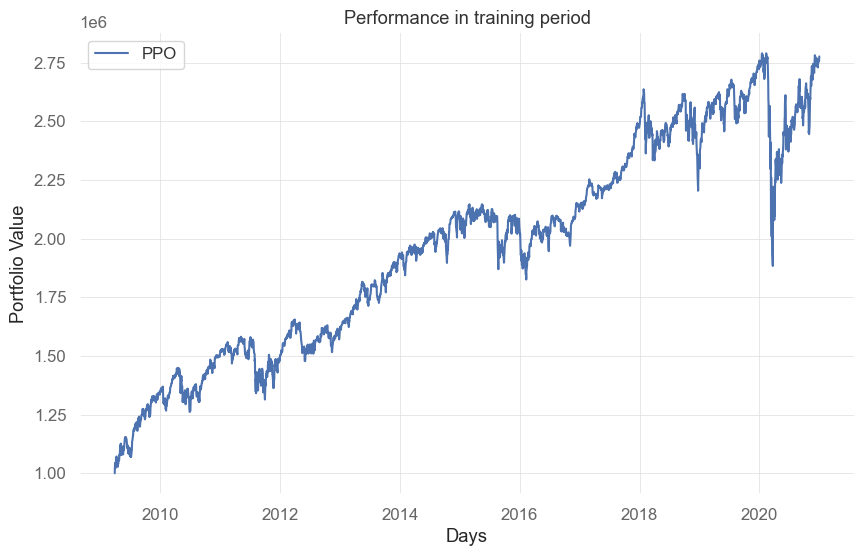

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

In [ ]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(DOW_30_TICKER)



# This is the CRP strategy NOT Buy and hold 
# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._terminal_asset_memory["final"]
UBAH_results["train"]["date"] = environment._terminal_date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._terminal_date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._terminal_asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._terminal_date_memory

Initial portfolio value:1000000
Final portfolio value: 7940020.0
Final accumulative portfolio value: 7.94002
Maximum DrawDown: -0.33119691335965773
Sharpe ratio: 1.1059664442187633
Total commission cost: 87049.05401602923
Initial portfolio value:1000000
Final portfolio value: 1213572.625
Final accumulative portfolio value: 1.213572625
Maximum DrawDown: -0.06613150524146016
Sharpe ratio: 1.686899284452737
Total commission cost: 2419.6810859934194
Initial portfolio value:1000000
Final portfolio value: 921179.5625
Final accumulative portfolio value: 0.9211795625
Maximum DrawDown: -0.21710192092751635
Sharpe ratio: -0.314011289071912
Total commission cost: 2328.910278096213


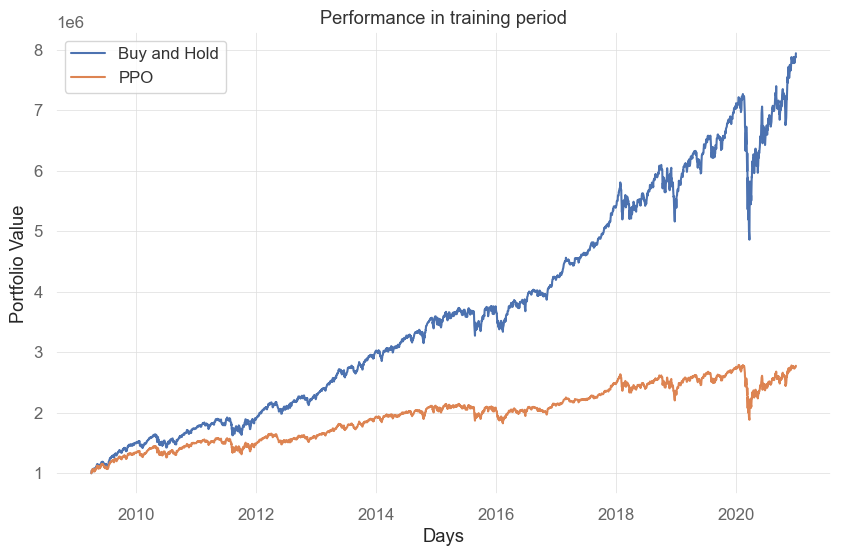

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

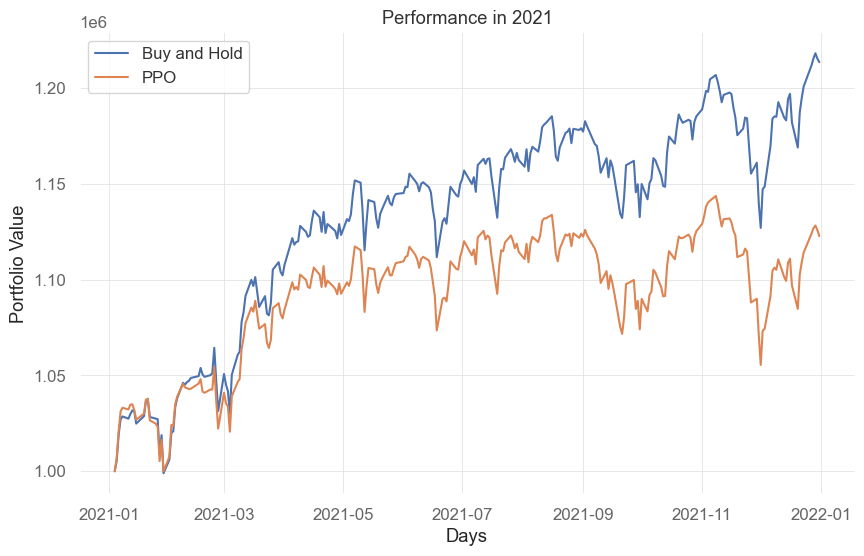

In [ ]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2021"]["date"], PPO_results["2021"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

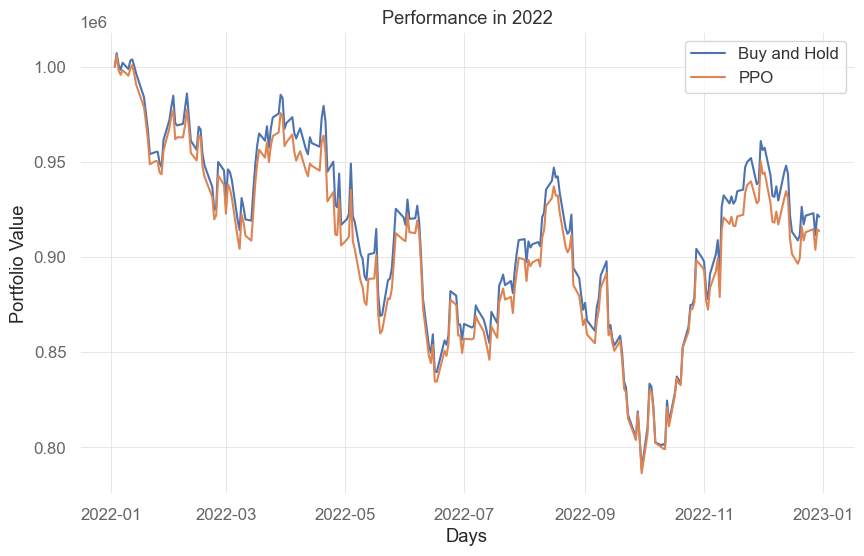

In [ ]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2022"]["date"], PPO_results["2022"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

In [ ]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(PPO_results["2023"]["date"], PPO_results["2023"]["value"], label="PPO")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()